## Data Diri
* Nama : Febby Ariyanti Herdiana
* Grup : M06

In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Bidirectional, Dropout 
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import sklearn.preprocessing
from keras.models import Sequential
from sklearn.metrics import r2_score

In [ ]:
data_train = pd.read_csv('/content/goldtimeseries.zip')
data_train

,Date,Value
0,1970-01-01,35.20
1,1970-04-01,35.10
2,1970-07-01,35.40
3,1970-10-01,36.20
4,1971-01-01,37.40
...,...,...
10782,2020-03-09,1672.50
10783,2020-03-10,1655.70
10784,2020-03-11,1653.75
10785,2020-03-12,1570.70


In [ ]:
data_train.isnull().sum()

Date     0
Value    0
dtype: int64

In [ ]:
def normalize_data(data_train):
    scaler = sklearn.preprocessing.MinMaxScaler()
    data_train['Value']=scaler.fit_transform(data_train['Value'].values.reshape(-1,1))
    return data_train

df_norm = normalize_data(data_train)
df_norm.shape

(10787, 2)

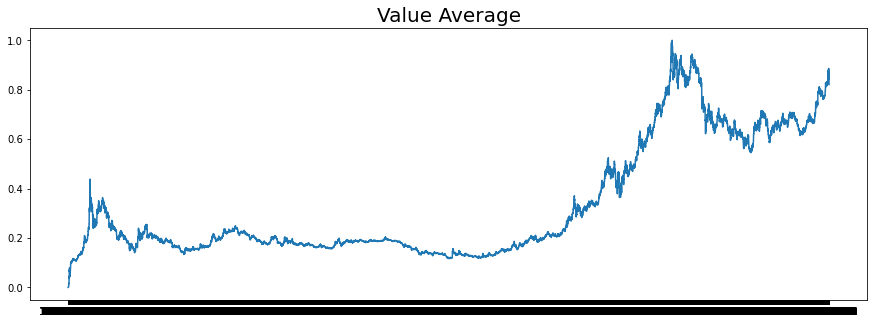

In [ ]:
date = data_train['Date'].values
value  = data_train['Value'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(date, value)
plt.title('Value Average',
          fontsize=20);

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(value, date, train_size=0.8, test_size=0.2, shuffle=False )

In [ ]:
print('Total Data Train : ',len(x_train))
print('Total Data Validation : ',len(x_valid))

Total Data Train :  8629
Total Data Validation :  2158


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(x_valid, window_size=60, batch_size=200, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
                                    Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
                                    Bidirectional(tf.keras.layers.LSTM(60, dropout=0.2)),
                                    Dense(16, activation="relu"),
                                    Dropout(0.2),
                                    Dense(8, activation="relu"),
                                    Dense(1),
])

In [ ]:
minMae = (data_train['Value'].max() - data_train['Value'].min()) * 10 / 100 
minMae

0.1

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < minMae and logs.get('val_mae') < minMae):
      print("\MAE dari model < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,
                    epochs=100,
                    validation_data=val_set,
                    callbacks=[callbacks])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


108/108 [==============================] - 37s 273ms/step - loss: 0.0614 - mae: 0.2855 - val_loss: 0.1564 - val_mae: 0.5532
Epoch 2/100
108/108 [==============================] - 29s 263ms/step - loss: 0.0385 - mae: 0.1932 - val_loss: 0.1117 - val_mae: 0.4660
Epoch 3/100
108/108 [==============================] - 27s 251ms/step - loss: 0.0293 - mae: 0.1537 - val_loss: 0.0864 - val_mae: 0.4085
Epoch 4/100
108/108 [==============================] - 28s 254ms/step - loss: 0.0244 - mae: 0.1515 - val_loss: 0.0707 - val_mae: 0.3683
Epoch 5/100
108/108 [==============================] - 27s 252ms/step - loss: 0.0222 - mae: 0.1547 - val_loss: 0.0605 - val_mae: 0.3396
Epoch 6/100
108/108 [==============================] - 27s 251ms/step - loss: 0.0209 - mae: 0.1575 - val_loss: 0.0537 - val_mae: 0.3191
Epoch 7/100
108/108 [==============================] - 28s 253ms/step - loss: 0.0204 - mae: 0.1600 - val_loss: 0.0492 - val_mae: 0.3049
Epoch 8/100
108/108 [==============================] - 27s 2

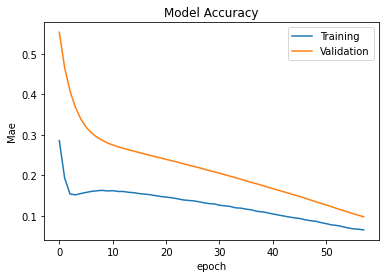

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('Mae')
plt.legend(['Training', 'Validation'], loc = 'best')
plt.show()

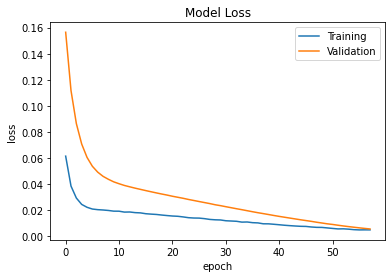

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'], loc = 'best')
plt.show()